In [1]:
### 설치
!pip install mxnet
!pip install gluonnlp==0.8.0
!pip install sentencepiece
!pip install transformers
!pip install torch

In [2]:
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-g4kk48yt/kobert-tokenizer_9c133d9f3d994e119478d9d714e5e0b7
  Running command git clone --filter=blob:none --quiet https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-g4kk48yt/kobert-tokenizer_9c133d9f3d994e119478d9d714e5e0b7
  Resolved https://github.com/SKTBrain/KoBERT.git to commit 47a69af87928fc24e20f571fe10c3cc9dd9af9a3
  Preparing metadata (setup.py) ... done


In [15]:
### 라이브러리
import numpy as np
np.bool = np.bool_
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
from tqdm import tqdm, tqdm_notebook
from kobert_tokenizer import KoBERTTokenizer
from transformers import BertModel
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [16]:
### csv 데이터를 tsv 파일로 변환
%cd '/content/drive/MyDrive/[2024-1] EURON 6기/프로젝트/'
train = pd.read_csv("review_train.csv", encoding='utf-8')
test = pd.read_csv("review_test.csv", encoding='utf-8')

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
n = train.shape[0]
df = pd.concat([train, test])
df['keyword2'] = le.fit_transform(df['keyword2'])
train = df[:n]
test = df[n:]

train.to_csv('review_train.tsv', sep='\t', encoding='utf-8-sig', index=False)
test.to_csv('review_test.tsv', sep='\t', encoding='utf-8-sig', index=False)

/content/drive/MyDrive/[2024-1] EURON 6기/프로젝트


In [17]:
### tokenizer와 Bert 모델, vocab 불러오기
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')  # hugging-face
bertmodel = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


In [23]:
train_dataset = nlp.data.TSVDataset(
    "./review_train.tsv", field_indices=[0,1], num_discard_samples=1)
test_dataset = nlp.data.TSVDataset(
    "./review_test.tsv", field_indices=[0,1], num_discard_samples=1)

from sklearn.model_selection import train_test_split
train_dataset, valid_dataset = train_test_split(
    train_dataset, test_size=0.2, random_state=2024)

In [24]:
### BERTDataset 클래스 정의
# 토큰화, 패딩, 어텐션 마스크 생성
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len, pad, pair):
        self.tokenizer = bert_tokenizer
        self.max_len = max_len
        self.pad = pad
        self.pair = pair

        self.sentences = [i[sent_idx] for i in dataset]
        self.labels = [int(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        sentence = self.sentences[i]
        label = self.labels[i]

        inputs = self.tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=self.pad,
            return_tensors='pt',
            truncation=True
        )

        input_ids = inputs['input_ids'].squeeze()
        attention_mask = inputs['attention_mask'].squeeze()
        segment_ids = torch.zeros_like(input_ids)
        valid_length = torch.sum(attention_mask)

        return input_ids, valid_length, segment_ids, label

    def __len__(self):
        return len(self.labels)

In [35]:
### 파라미터 설정
max_len = 400
batch_size = 2
warmup_ratio = 0.1
num_epochs = 20
max_grad_norm = 1
log_interval = 200
learning_rate = 5e-5

In [36]:
### 데이터
train_data = BERTDataset(train_dataset, 0, 1, tokenizer, max_len, True, False)
valid_data = BERTDataset(valid_dataset, 0, 1, tokenizer, max_len, True, False)
test_data = BERTDataset(test_dataset, 0, 1, tokenizer, max_len, True, False)

### 데이터로더
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=False)

In [37]:
### KoBERT 모델링
class BERTClassifier(nn.Module):
    def __init__(self, bert, hidden_size = 768,
                 num_classes=13, dr_rate=None, params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

        self.classifier = nn.Linear(hidden_size , num_classes)
        self.dropout = nn.Dropout(p=dr_rate) if dr_rate is not None else None

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)

        _, pooler = self.bert(input_ids=token_ids, token_type_ids=segment_ids.long(),
                              attention_mask=attention_mask.float().to(token_ids.device))
        if self.dropout:
            pooler = self.dropout(pooler)

        output = self.classifier(pooler)
        return output

In [38]:
### 모델 선언
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TORCH_USE_CUDA_DSA"] = '1'

model = BERTClassifier(bertmodel, dr_rate=0.5).to(device)

In [39]:
### 옵티마이저 설정
# 모델의 매개변수 그룹 설정
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
     'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
     'weight_decay': 0.0}
]

# AdamW 옵티마이저 설정
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)

# 손실 함수 설정
loss_fn = nn.CrossEntropyLoss()

# 총 학습 스텝 계산
t_total = len(train_dataloader) * num_epochs

# 웜업 스텝 계산
warmup_steps = int(t_total * warmup_ratio)

# 스케줄러 설정
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=t_total
)

In [40]:
### 정확도 계산 함수
def calc_accuracy(X,Y):
  max_vals, max_indices = torch.max(X, 1)
  train_acc = (max_indices==Y).sum().data.cpu().numpy()/max_indices.size()[0]
  return train_acc

### f1 score 계산 함수
def calc_f1_score(X, Y):
    from sklearn.metrics import f1_score
    max_vals, max_indices = torch.max(X, 1)
    y_pred = max_indices.cpu().numpy()
    y_true = Y.cpu().numpy()
    f1 = f1_score(y_true, y_pred, average='macro')  # 'macro'로 설정하여 클래스별 가중치를 동일하게 처리
    return f1

In [41]:
for e in range(num_epochs):
    train_acc = 0.0
    train_f1 = 0.0
    valid_acc = 0.0
    valid_f1 = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()
        train_acc += calc_accuracy(out, label)
        train_f1 += calc_f1_score(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    print("epoch {} train f1 {}".format(e+1, train_f1 / (batch_id+1)))

    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(valid_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        valid_acc += calc_accuracy(out, label)
        valid_f1 += calc_f1_score(out, label)
    print("epoch {} valid acc {}".format(e+1, valid_acc / (batch_id+1)))
    print("epoch {} valid f1 {}".format(e+1, valid_f1 / (batch_id+1)))

  0%|          | 0/810 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 2.800072193145752 train acc 0.0
epoch 1 batch id 201 loss 2.2980401515960693 train acc 0.09203980099502487
epoch 1 batch id 401 loss 2.9463746547698975 train acc 0.09725685785536159
epoch 1 batch id 601 loss 2.5084590911865234 train acc 0.11397670549084858
epoch 1 batch id 801 loss 2.085411548614502 train acc 0.15168539325842698
epoch 1 train acc 0.15308641975308643
epoch 1 train f1 0.11234567901234561


  0%|          | 0/203 [00:00<?, ?it/s]

epoch 1 valid acc 0.2512315270935961
epoch 1 valid f1 0.19211822660098526


  0%|          | 0/810 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 1.183631420135498 train acc 0.5
epoch 2 batch id 201 loss 1.8943769931793213 train acc 0.3308457711442786
epoch 2 batch id 401 loss 0.9533509016036987 train acc 0.31296758104738154
epoch 2 batch id 601 loss 3.3985843658447266 train acc 0.324459234608985
epoch 2 batch id 801 loss 2.363368272781372 train acc 0.32459425717852686
epoch 2 train acc 0.3253086419753086
epoch 2 train f1 0.25226337448559766


  0%|          | 0/203 [00:00<?, ?it/s]

epoch 2 valid acc 0.31527093596059114
epoch 2 valid f1 0.24302134646962248


  0%|          | 0/810 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 2.3523616790771484 train acc 0.5
epoch 3 batch id 201 loss 2.02795147895813 train acc 0.31592039800995025
epoch 3 batch id 401 loss 2.4308574199676514 train acc 0.3428927680798005
epoch 3 batch id 601 loss 1.0765365362167358 train acc 0.35856905158069885
epoch 3 batch id 801 loss 2.5562992095947266 train acc 0.35518102372034954
epoch 3 train acc 0.35617283950617284
epoch 3 train f1 0.27860082304526884


  0%|          | 0/203 [00:00<?, ?it/s]

epoch 3 valid acc 0.3448275862068966
epoch 3 valid f1 0.27914614121510706


  0%|          | 0/810 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 1.5173931121826172 train acc 0.0
epoch 4 batch id 201 loss 2.7470483779907227 train acc 0.42039800995024873
epoch 4 batch id 401 loss 0.8390859365463257 train acc 0.46384039900249374
epoch 4 batch id 601 loss 0.8892844319343567 train acc 0.46422628951747086
epoch 4 batch id 801 loss 0.333952397108078 train acc 0.47253433208489387
epoch 4 train acc 0.4722222222222222
epoch 4 train f1 0.3897119341563782


  0%|          | 0/203 [00:00<?, ?it/s]

epoch 4 valid acc 0.46551724137931033
epoch 4 valid f1 0.38423645320197036


  0%|          | 0/810 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.2698591947555542 train acc 1.0
epoch 5 batch id 201 loss 0.67957603931427 train acc 0.47761194029850745
epoch 5 batch id 401 loss 2.041266441345215 train acc 0.5012468827930174
epoch 5 batch id 601 loss 1.4013936519622803 train acc 0.4983361064891847
epoch 5 batch id 801 loss 0.37135815620422363 train acc 0.49625468164794007
epoch 5 train acc 0.49506172839506174
epoch 5 train f1 0.41275720164608926


  0%|          | 0/203 [00:00<?, ?it/s]

epoch 5 valid acc 0.5
epoch 5 valid f1 0.4121510673234808


  0%|          | 0/810 [00:00<?, ?it/s]

epoch 6 batch id 1 loss 1.3595894575119019 train acc 0.5
epoch 6 batch id 201 loss 1.5618703365325928 train acc 0.5522388059701493
epoch 6 batch id 401 loss 1.2735928297042847 train acc 0.5511221945137157
epoch 6 batch id 601 loss 0.011037813499569893 train acc 0.5515806988352745
epoch 6 batch id 801 loss 1.4466156959533691 train acc 0.5686641697877652
epoch 6 train acc 0.5685185185185185
epoch 6 train f1 0.4946502057613153


  0%|          | 0/203 [00:00<?, ?it/s]

epoch 6 valid acc 0.5738916256157636
epoch 6 valid f1 0.499178981937602


  0%|          | 0/810 [00:00<?, ?it/s]

epoch 7 batch id 1 loss 0.15312515199184418 train acc 1.0
epoch 7 batch id 201 loss 2.2895660400390625 train acc 0.6218905472636815
epoch 7 batch id 401 loss 0.6808464527130127 train acc 0.6321695760598504
epoch 7 batch id 601 loss 0.9431778192520142 train acc 0.6256239600665557
epoch 7 batch id 801 loss 1.5478733777999878 train acc 0.632334581772784
epoch 7 train acc 0.6320987654320988
epoch 7 train f1 0.5510288065843593


  0%|          | 0/203 [00:00<?, ?it/s]

epoch 7 valid acc 0.6009852216748769
epoch 7 valid f1 0.5254515599343179


  0%|          | 0/810 [00:00<?, ?it/s]

epoch 8 batch id 1 loss 0.04612617939710617 train acc 1.0
epoch 8 batch id 201 loss 1.3746877908706665 train acc 0.6616915422885572
epoch 8 batch id 401 loss 0.25676241517066956 train acc 0.6583541147132169
epoch 8 batch id 601 loss 0.026554595679044724 train acc 0.6780366056572379
epoch 8 batch id 801 loss 0.008961278013885021 train acc 0.6935081148564295
epoch 8 train acc 0.6932098765432099
epoch 8 train f1 0.6213991769547293


  0%|          | 0/203 [00:00<?, ?it/s]

epoch 8 valid acc 0.6773399014778325
epoch 8 valid f1 0.6026272577996709


  0%|          | 0/810 [00:00<?, ?it/s]

epoch 9 batch id 1 loss 0.27896514534950256 train acc 1.0
epoch 9 batch id 201 loss 1.1224117279052734 train acc 0.7562189054726368
epoch 9 batch id 401 loss 0.1797904670238495 train acc 0.7593516209476309
epoch 9 batch id 601 loss 0.8499541282653809 train acc 0.7603993344425957
epoch 9 batch id 801 loss 0.719367504119873 train acc 0.7609238451935081
epoch 9 train acc 0.7611111111111111
epoch 9 train f1 0.7008230452674888


  0%|          | 0/203 [00:00<?, ?it/s]

epoch 9 valid acc 0.7142857142857143
epoch 9 valid f1 0.6469622331691289


  0%|          | 0/810 [00:00<?, ?it/s]

epoch 10 batch id 1 loss 0.01683216355741024 train acc 1.0
epoch 10 batch id 201 loss 0.023964572697877884 train acc 0.7985074626865671
epoch 10 batch id 401 loss 1.0486780405044556 train acc 0.7830423940149626
epoch 10 batch id 601 loss 0.019913464784622192 train acc 0.7986688851913477
epoch 10 batch id 801 loss 0.0022741726133972406 train acc 0.8046192259675405
epoch 10 train acc 0.8037037037037037
epoch 10 train f1 0.7510288065843617


  0%|          | 0/203 [00:00<?, ?it/s]

epoch 10 valid acc 0.729064039408867
epoch 10 valid f1 0.6617405582922814


  0%|          | 0/810 [00:00<?, ?it/s]

epoch 11 batch id 1 loss 0.02565181255340576 train acc 1.0
epoch 11 batch id 201 loss 0.2802714705467224 train acc 0.8283582089552238
epoch 11 batch id 401 loss 3.636512517929077 train acc 0.8391521197007481
epoch 11 batch id 601 loss 0.025070469826459885 train acc 0.8410981697171381
epoch 11 batch id 801 loss 0.05101554095745087 train acc 0.8377028714107366
epoch 11 train acc 0.8358024691358025
epoch 11 train f1 0.7917695473251033


  0%|          | 0/203 [00:00<?, ?it/s]

epoch 11 valid acc 0.7512315270935961
epoch 11 valid f1 0.6962233169129717


  0%|          | 0/810 [00:00<?, ?it/s]

epoch 12 batch id 1 loss 0.7225511074066162 train acc 0.5
epoch 12 batch id 201 loss 0.007926683872938156 train acc 0.8681592039800995
epoch 12 batch id 401 loss 2.0174508094787598 train acc 0.8952618453865336
epoch 12 batch id 601 loss 0.001026341924443841 train acc 0.9001663893510815
epoch 12 batch id 801 loss 0.0010617137886583805 train acc 0.8957553058676654
epoch 12 train acc 0.8962962962962963
epoch 12 train f1 0.8637860082304543


  0%|          | 0/203 [00:00<?, ?it/s]

epoch 12 valid acc 0.7807881773399015
epoch 12 valid f1 0.7257799671592773


  0%|          | 0/810 [00:00<?, ?it/s]

epoch 13 batch id 1 loss 0.0021213230211287737 train acc 1.0
epoch 13 batch id 201 loss 0.011468309909105301 train acc 0.9427860696517413
epoch 13 batch id 401 loss 0.004123340826481581 train acc 0.940149625935162
epoch 13 batch id 601 loss 0.000979996402747929 train acc 0.937603993344426
epoch 13 batch id 801 loss 0.0913756787776947 train acc 0.9375780274656679
epoch 13 train acc 0.937037037037037
epoch 13 train f1 0.9176954732510295


  0%|          | 0/203 [00:00<?, ?it/s]

epoch 13 valid acc 0.7857142857142857
epoch 13 valid f1 0.7307060755336614


  0%|          | 0/810 [00:00<?, ?it/s]

epoch 14 batch id 1 loss 0.0004673914227169007 train acc 1.0
epoch 14 batch id 201 loss 0.0018154364079236984 train acc 0.9601990049751243
epoch 14 batch id 401 loss 0.0010471886489540339 train acc 0.9613466334164589
epoch 14 batch id 601 loss 0.001922666560858488 train acc 0.9600665557404326
epoch 14 batch id 801 loss 0.0003782714775297791 train acc 0.9631710362047441
epoch 14 train acc 0.9635802469135802
epoch 14 train f1 0.951851851851852


  0%|          | 0/203 [00:00<?, ?it/s]

epoch 14 valid acc 0.8103448275862069
epoch 14 valid f1 0.7619047619047618


  0%|          | 0/810 [00:00<?, ?it/s]

epoch 15 batch id 1 loss 0.0006286190473474562 train acc 1.0
epoch 15 batch id 201 loss 0.0017929010791704059 train acc 0.9825870646766169
epoch 15 batch id 401 loss 0.0007536821649409831 train acc 0.9763092269326683
epoch 15 batch id 601 loss 0.00047606811858713627 train acc 0.978369384359401
epoch 15 batch id 801 loss 0.0014112128410488367 train acc 0.9750312109862672
epoch 15 train acc 0.9753086419753086
epoch 15 train f1 0.967489711934157


  0%|          | 0/203 [00:00<?, ?it/s]

epoch 15 valid acc 0.8177339901477833
epoch 15 valid f1 0.7701149425287351


  0%|          | 0/810 [00:00<?, ?it/s]

epoch 16 batch id 1 loss 0.0004927811678498983 train acc 1.0
epoch 16 batch id 201 loss 0.0019314558012410998 train acc 0.9925373134328358
epoch 16 batch id 401 loss 0.0016533082816749811 train acc 0.9900249376558603
epoch 16 batch id 601 loss 0.00028293533250689507 train acc 0.9891846921797005
epoch 16 batch id 801 loss 0.0025411145761609077 train acc 0.9900124843945068
epoch 16 train acc 0.9901234567901235
epoch 16 train f1 0.9868312757201646


  0%|          | 0/203 [00:00<?, ?it/s]

epoch 16 valid acc 0.8300492610837439
epoch 16 valid f1 0.7848932676518882


  0%|          | 0/810 [00:00<?, ?it/s]

epoch 17 batch id 1 loss 0.0010823460761457682 train acc 1.0
epoch 17 batch id 201 loss 0.000593725242651999 train acc 0.9975124378109452
epoch 17 batch id 401 loss 0.00044446007814258337 train acc 0.9950124688279302
epoch 17 batch id 601 loss 0.0003413321974221617 train acc 0.9950083194675541
epoch 17 batch id 801 loss 0.0005264069186523557 train acc 0.9943820224719101
epoch 17 train acc 0.9944444444444445
epoch 17 train f1 0.9925925925925927


  0%|          | 0/203 [00:00<?, ?it/s]

epoch 17 valid acc 0.8374384236453202
epoch 17 valid f1 0.7963875205254514


  0%|          | 0/810 [00:00<?, ?it/s]

epoch 18 batch id 1 loss 0.0002550639328546822 train acc 1.0
epoch 18 batch id 201 loss 0.0004996357019990683 train acc 0.9975124378109452
epoch 18 batch id 401 loss 0.002076247939839959 train acc 0.9975062344139651
epoch 18 batch id 601 loss 0.00035844440571963787 train acc 0.997504159733777
epoch 18 batch id 801 loss 0.0002381516242166981 train acc 0.9968789013732834
epoch 18 train acc 0.9969135802469136
epoch 18 train f1 0.9958847736625516


  0%|          | 0/203 [00:00<?, ?it/s]

epoch 18 valid acc 0.8374384236453202
epoch 18 valid f1 0.7963875205254514


  0%|          | 0/810 [00:00<?, ?it/s]

epoch 19 batch id 1 loss 0.0015381245175376534 train acc 1.0
epoch 19 batch id 201 loss 0.00015787893789820373 train acc 1.0
epoch 19 batch id 401 loss 0.00033503532176837325 train acc 0.9962593516209476
epoch 19 batch id 601 loss 0.00039299868512898684 train acc 0.997504159733777
epoch 19 batch id 801 loss 0.0004298315034247935 train acc 0.9975031210986267
epoch 19 train acc 0.9975308641975309
epoch 19 train f1 0.9967078189300412


  0%|          | 0/203 [00:00<?, ?it/s]

epoch 19 valid acc 0.8325123152709359
epoch 19 valid f1 0.7898193760262724


  0%|          | 0/810 [00:00<?, ?it/s]

epoch 20 batch id 1 loss 0.0003009578213095665 train acc 1.0
epoch 20 batch id 201 loss 0.00027616979787126184 train acc 0.9950248756218906
epoch 20 batch id 401 loss 0.0012140655890107155 train acc 0.9975062344139651
epoch 20 batch id 601 loss 0.002712506102398038 train acc 0.9966722129783694
epoch 20 batch id 801 loss 0.0006517349975183606 train acc 0.9968789013732834
epoch 20 train acc 0.9969135802469136
epoch 20 train f1 0.9958847736625516


  0%|          | 0/203 [00:00<?, ?it/s]

epoch 20 valid acc 0.8349753694581281
epoch 20 valid f1 0.7931034482758619


In [59]:
### 분류
prediction = []
y_label = []
for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
  token_ids = token_ids.long().to(device)
  segment_ids = segment_ids.long().to(device)
  valid_length= valid_length
  out = model(token_ids, valid_length, segment_ids)
  prediction.append(out.cpu().detach().numpy().argmax())
  y_label.append(label.cpu().detach().numpy())

from sklearn.metrics import accuracy_score, f1_score
print('test 정확도 :', accuracy_score(y_label, prediction))
print('test f1 score :', f1_score(y_label, prediction, average='weighted'))

  0%|          | 0/400 [00:00<?, ?it/s]

test 정확도 : 0.26
test f1 score : 0.26181689926670154


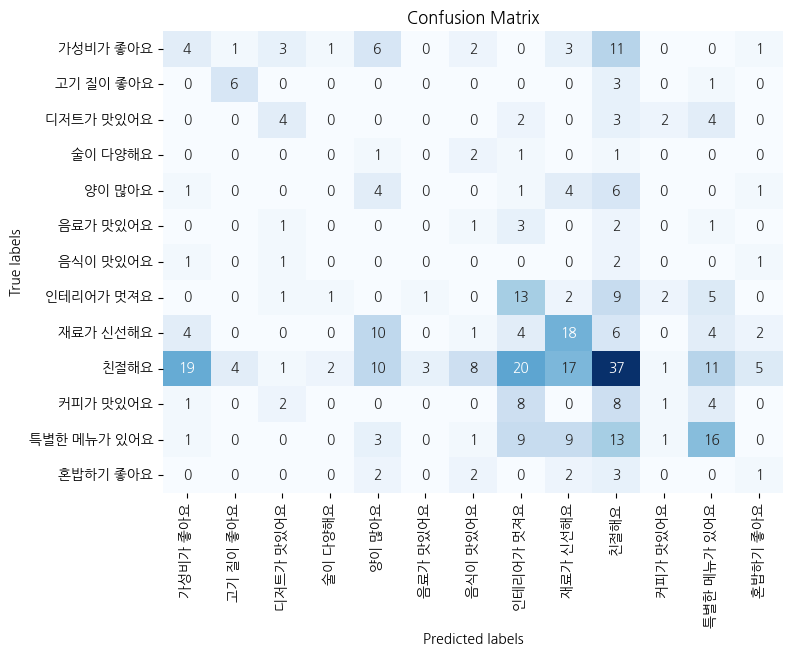

In [60]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

!apt-get install -qq fonts-nanum
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fm.fontManager.addfont(font_path)
plt.rc('font', family='NanumGothic')


from sklearn.metrics import confusion_matrix

col = le.classes_
cm = confusion_matrix(y_label, prediction)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=col, yticklabels=col)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()